Hierarchical Bayes and Gibbs Sampling Example: Teenagers' Heights
=======================================================


This notebook will take you though an example of the construction of a hierarchical Bayesian model for the evolution of the heights of a population of teenagers with age. We will then sample from the posterior distribution for some mock data using Gibbs sampling.

First we will build a generative model for mock height measurements. Then we will build a Bayesian hierarchical model and write down the posterior probability distribution. Finally, we will use Gibbs sampling to reclaim the input parameters of our generative model.

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

A generative model for measurements of teenagers' heights
----------------------------------------------------------------------

For each individual we will model their height, $y$ as a linear function of their age, $x$. For a series of measurements, $i$, the relationship is

$y_i = mx_i + c$.


We will further assume that for each individual, $j$, the parameters of the relationship, $m_j$ and $c_j$ are drawn from Gaussian distributions such that

$m_j \sim N(\mu_m, \sigma_m)$

$c_j \sim N(\mu_c, \sigma_c)$.

We can set up some code to generate some mock data as follows

In [24]:
# Set the population parameters
mu_c = 0.
sig_c = 10.
mu_m = 9.
sig_m = 1.

# Set the range of ages for which we have data
x_range = (10., 18.)

# Set the minimum error for each measurement.
error_floor = 5.

def generate_pop_params(n=500):
    ints = sig_c*np.random.randn(n) + mu_c
    grads = sig_m*np.random.randn(n) + mu_m
    population = []
    
    for i in range(n):
        N = np.random.randint(2, high=5)

        x_vals = (x_range[1] - x_range[0])*np.random.rand(N) + x_range[0]
        y_vals = grads[i]*x_vals + ints[i]
        y_sigs = error_floor + error_floor*np.random.randn(N)**2
        y_vals += y_sigs*np.random.randn(N)
        population.append(np.c_[x_vals, y_vals, y_sigs])


    return ints, grads, population

In [25]:
ints, grads, population = generate_pop_params()

The distribution of population parameters looks like this:

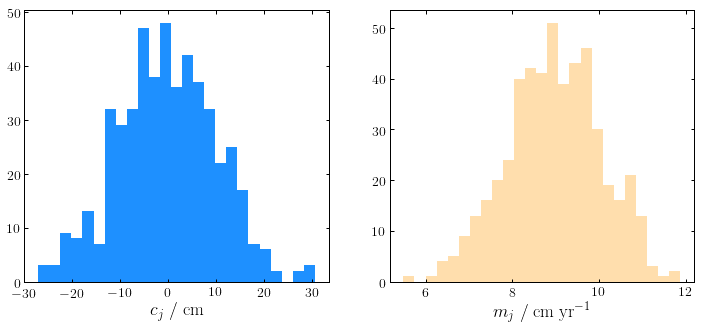

In [26]:
plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.hist(ints, color="dodgerblue", bins=25)
ax2.hist(grads, color="navajowhite", bins=25)
ax1.set_xlabel("$c_j\\ /\\ \\mathrm{cm}$")
ax2.set_xlabel("$m_j\\ /\\ \\mathrm{cm\\ yr^{-1}}$")
plt.show()

The relationships for a few example individuals look like this (the solid lines are the input relationships, the points show the samples we generated):

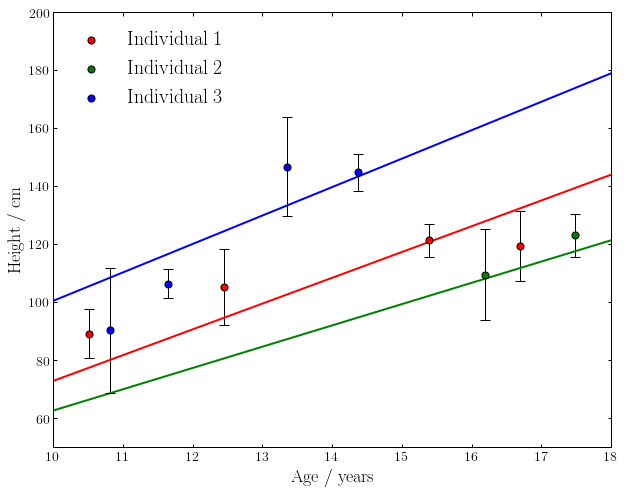

In [54]:
plt.figure(figsize=(10, 8))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")

x = np.arange(10, 18, 0.01)

colors = ["red", "green", "blue"]

for i in range(3):
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color=colors[i])
    plt.errorbar(data[:,0], data[:,1], data[:,2], ls="", capsize=5, color="black", lw=1)
    plt.scatter(data[:,0], data[:,1], color=colors[i], lw=1, edgecolor="black", zorder=10,
                s=50, label="$\\mathrm{Individual\\ " + str(i+1) + "}$")

plt.legend(frameon=False, fontsize=20)
plt.show()

A classical approach: fitting individual objects using a maximum likelihood method
-------------------------------------------------------------------------------------------------

Now that we have our generative model, and resulting mock data samples, let's try a classical approach by fitting a straight line model to each individual using a maximum likelihood (chi-squared) method. Numpy provides a function to do this in a single line of code, the resulting best fits are shown in gray:

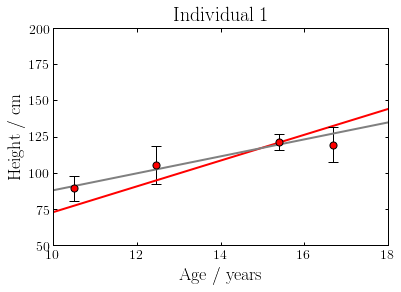

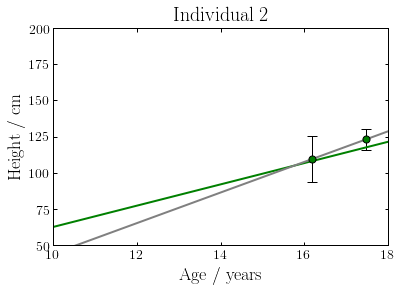

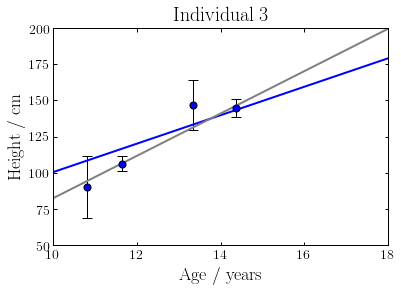

In [53]:
for i in range(3):
    plt.figure(figsize=(6, 4))
    plt.xlim(10, 18)
    plt.ylim(50, 200)
    plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
    plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
    plt.title("$\\mathrm{Individual\\ " + str(i+1) + "}$", size=20)
    
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color=colors[i])
    plt.errorbar(data[:,0], data[:,1], data[:,2], ls="", capsize=5, color="black", lw=1)
    plt.scatter(data[:,0], data[:,1], color=colors[i], lw=1, edgecolor="black", zorder=10, s=50)
    param = np.polyfit(data[:,0], data[:,1], 1, w=1/data[:,2])
    plt.plot(x, param[0]*x + param[1], color="gray")

    plt.show()



As you can see the results aren't always particularly close to the input relationships. This is by design: some of the individuals only have two noisy datapoints and therefore their growth rates are poorly constrained. Let's compare the input and recovered relationships for the whole population:

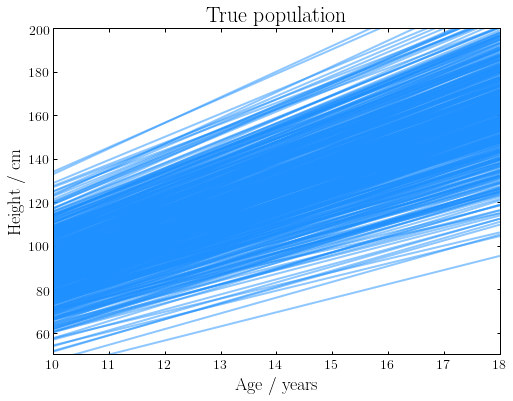

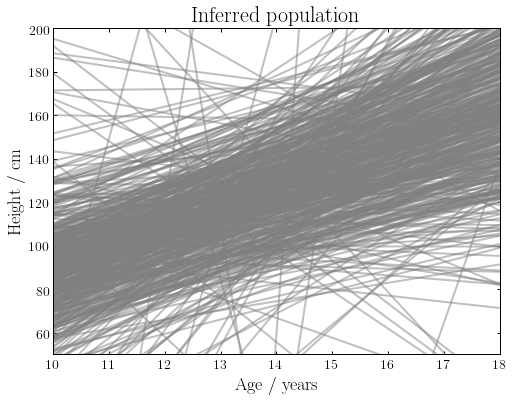

In [48]:
fig = plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{True\\ population}$", fontsize=22)

for i in range(500):
    data = population[i]
    plt.plot(x, grads[i]*x + ints[i], color="dodgerblue", alpha=0.5)

plt.show()

plt.figure(figsize=(8, 6))
plt.xlim(10, 18)
plt.ylim(50, 200)
plt.xlabel("$\\mathrm{Age\\ /\\ years}$")
plt.ylabel("$\\mathrm{Height\\ /\\ cm}$")
plt.title("$\\mathrm{Inferred\\ population}$", fontsize=22)

for i in range(500):
    data = population[i]
    param = np.polyfit(data[:,0], data[:,1], 1, w=1/data[:,2])
    plt.plot(x, param[0]*x + param[1], color="gray", alpha=0.5)

plt.show()

You can see that for the majority of objects the true distribution is relatively well recovered. However, for a significant fraction of the population, the data is very poorly constraining, resulting in individuals for which the inferred relationships look nothing like the input population.

However, we're not really making use of all the information we have for these individuals. Whilst we know relatively little about their individual growth rates, we know that they are members of a population with similar properties. In this case we can "borrow" constraining power from the population as a whole in order to better constrain the growth rates of individuals.

Setting up our hierarchical Bayesian model
--------------------------------------------------

We can do this by the use of a hierarchical Bayesian model. The idea here is to use the population statistics (the two Gaussian distributions for $m_j$ and $c_j$) as priors to apply to the $m$ and $c$ values for individual growth rates. We will constrain the population parameters $\mu_m, \mu_c, \sigma_m$ and $\sigma_c$ using our whole dataset, as well as constraining each of the $\{m_j\}$ and $\{c_j\}$.

We start by writing down the quantity we want to know, the posterior distribution: the probability of a set of model parameters given our observations $\{y_i\}_j$

$P(\mu_m,\ \mu_c,\ \sigma_m,\ \sigma_c,\ \{m_j\},\ \{c_j\}\ |\ \{y_i\}_j)$.

For readability let's compress this to:

$P(\mu,\ \sigma,\ m,\ c\ |\ y)$.

In order to manipulate this into a useful form we're going to need some standard results from probability theory:

> Firstly, the product rule states that
>
> $P(x,\ y) = P(x\ |\ y)\ P(y)$.
>
> From this we can directly obtain Bayes' theorem by
>
> $P(y,\ x) = P(x,\ y)$
>
> $P(y\ |\ x)\ P(x) = P(x\ |\ y)\ P(y)$
>
> $P(y\ |\ x) = \dfrac{P(x\ |\ y)\ P(y)}{P(x)}$

We can use this to flip our distribution, we're not particularly interested in the normalisation so

$P(\mu,\ \sigma,\ m,\ c\ |\ y) \propto P(y\ |\ \mu,\ \sigma,\ m,\ c)\ P(\mu,\ \sigma,\ m,\ c)$.






